# Topic Estimation Steps:


1. Text preprocessing and tokenization

2. Train topic estimation model
    - Make document-term matrix
        - input: tokens 
        - tool: CountVectorizer
    - Make topic distribution matrix
        - input:
            i) document-term matrix -> term-document matrix -> corpus
            ii) dictionary (from gensim, Not pandas dict)
    - Train model: Latent Dirichlet Allocation
    - Hyperparameter tuning: choose topic count
        - evaluate model using coherence measure - degree of similarity among words in the same topic
            - use c_umass
        
3. Visualization model
    - tool: pyLDAvis
    - also, each piece of text is expressed in terms of a list of topics, and the probability for each topic


## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import time
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim import corpora
from gensim import matutils, models
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import pyLDAvis
import pyLDAvis.gensim_models


In [2]:
# in order to use NLTK's lemmatizer, need to download library

import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

# to see where it is downloaded to
print(nltk.find('corpora/wordnet.zip'))

/Users/carmen/nltk_data/corpora/wordnet.zip


# 1. Text preprocessing and tokenization

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df = pd.read_excel('../data/drug_names_kaggle_TASK.xlsx',
                  header = 1,
                  usecols = [1])

In [6]:
df.head(2)

,Introduction
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding."
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding."


In [10]:
# test
test_sentence = "What're you doing next Wednesday? I love to eat cheeseburgers. Let's go to McDonald's."

In [11]:
tokenizer = RegexpTokenizer(r'\w+')
test_sentence = test_sentence.lower()
tokens = tokenizer.tokenize(test_sentence)
tokens

['what',
 're',
 'you',
 'doing',
 'next',
 'wednesday',
 'i',
 'love',
 'to',
 'eat',
 'cheeseburgers',
 'let',
 's',
 'go',
 'to',
 'mcdonald',
 's']

In [16]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
lemmatized_tokens

['next', 'wednesday', 'love', 'eat', 'cheeseburger', 'let', 'go', 'mcdonald']

In [25]:
def tokenize_and_lemmatize(text):
    
    list_str_exclude = ['mg', 'ml', 'gm', 'iu', 'mcg']
    # need to add words to this list manually
    
    ## tokenize ##
    tokenizer = RegexpTokenizer(r'\w+')
    text = text.lower()
    tokens = tokenizer.tokenize(text)

    ## Lemmatize and remove stop words ##
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    ## Further cleanup ##
    # Remove numbers, but not words that contain numbers.
    lemmatized_tokens = [lemmatized_token for lemmatized_token in lemmatized_tokens if not lemmatized_token.isnumeric()]

    # Remove words that are only one character.
    lemmatized_tokens = [lemmatized_token for lemmatized_token in lemmatized_tokens if len(lemmatized_token) > 1]
    
    # Remove words that are dosage
    lemmatized_tokens = [lemmatized_token for lemmatized_token in lemmatized_tokens if not any(unimportant in lemmatized_tokens for unimportant in list_str_exclude)]
    
    return lemmatized_tokens

In [26]:
df['tokens'] = df['Introduction'].apply(lambda x: tokenize_and_lemmatize(x))

In [27]:
df.head(2)

,Introduction,tokens
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, antibiotic, fight, bacteria, used, treat, acne, appears, spot, pimple, face, chest, back, medicine, work, attacking, bacteria, cause, pimple, acnesol, gel, meant, external, use, used, advised, doctor, normally, wash, dry, affected, area, applying, thin, layer, medicine, applied, broken, damaged, skin, avoid, contact, eye, nose, mouth, rinse, water, accidentally, get, area, may, take, several, week, symptom, improve, keep, using, medicine, regularly, stop, using, soon, acne, start, get, better, ask, doctor, stop, treatment, common, side, effect, like, minor, itching, burning, redness, skin, oily, skin, may, seen, people, usually, temporary, resolve, consult, doctor, bother, go, away, safe, medicine, inform, doctor, problem, bowel, ...]"
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, used, treating, various, respiratory, tract, disorder, associated, excessive, mucus, work, thinning, loosens, mucus, nose, windpipe, lung, make, easier, cough, ambrodil, syrup, taken, food, better, result, suggested, take, time, every, day, dose, often, take, depends, taking, doctor, decide, much, need, improve, symptom, advised, use, day, without, doctor, consultation, common, side, effect, medicine, include, vomiting, nausea, stomach, upset, talk, doctor, worried, side, effect, would, go, away, generally, advised, take, alcohol, treatment, taking, medicine, tell, doctor, liver, kidney, disease, stomach, problem, doctor, also, know, medicine, taking, many, may, make, med

# 2. Train topic estimation model

In [28]:
def create_corpus_dictonary(text_data, max_term_freq, min_term_count):

    def identity_tokenizer(text):
        return text
    
    # create document-term matrix
    count_vectorizer = CountVectorizer(tokenizer = identity_tokenizer,
                                      lowercase = False,
                                      max_df = max_term_freq, # ignoring terms that have a document frequency > x% of the number of document (by percentage)
                                      min_df = min_term_count) # ignoring terms that have a document frequency < x (count) 

    count_matrix = count_vectorizer.fit_transform(text_data)
    print('count_matrix.shape: ', count_matrix.shape)
    
    # create dictionary of index: term
    dictionary = count_vectorizer.get_feature_names_out()
    print('length of dictionary: ', len(dictionary))
    id2word = {v: k for v, k in enumerate(dictionary)}    
    # for coherence evaluation, create dictionary of term: index
    word2id = dict((k, v) for k, v in count_vectorizer.vocabulary_.items())

    d = corpora.Dictionary()
    d.id2token = id2word
    d.token2id = word2id

    
    # create term-document matrix
    count_matrix_T = count_matrix.transpose()
    # convert from sparse to proper format for LDA
    corpus = matutils.Sparse2Corpus(count_matrix_T)
    
    return corpus, d, id2word, word2id


In [29]:
def train_model_get_coherence_score(corpus, id2word, topic_count, word2id):
    
    passes = 10
    iterations = 50 # 50 is the default
    
    lda = models.LdaModel(corpus = corpus,
                          id2word = id2word,
                          num_topics = topic_count,
                          passes = passes,
                          iterations = iterations)
    
    # evaluation coherence
    coherence_model_lda = CoherenceModel(model = lda, 
                                         corpus = corpus, 
                                         dictionary = word2id, 
                                         coherence = 'u_mass'
                                        )
    coherence_lda = coherence_model_lda.get_coherence()
    
    return lda, coherence_lda
    

## Check what topic_count results in best coherence score
- using UMass coherence Score
    - ref: https://www.baeldung.com/cs/topic-modeling-coherence-score
    - calculates how often 2 words appear together in the corpus

In [30]:
starttime = time.time()

max_term_freq = 0.7
min_term_count = 1

Corpus, D, Id2word, Word2id = create_corpus_dictonary(df['tokens'], max_term_freq, min_term_count)
print('max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

elapsedtime = time.time() - starttime
print('time taken to calculate: {}'.format(elapsedtime))

count_matrix.shape:  (1000, 2686)
length of dictionary:  2686
max_term_freq = 0.7, min_term_count = 1
time taken to calculate: 0.061165809631347656


/Users/carmen/anaconda3/envs/streamlit_conda391/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [34]:
dict_coherence_score_topic_count = {}
for i in range(3, 10):
    Lda, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, i, Word2id)
    dict_coherence_score_topic_count[i] = Coherence_score

In [35]:
dict_coherence_score_topic_count = dict(sorted(dict_coherence_score_topic_count.items()))

Text(0.5, 1.0, 'Max_term_freq = 0.7, min_term_count = 1')

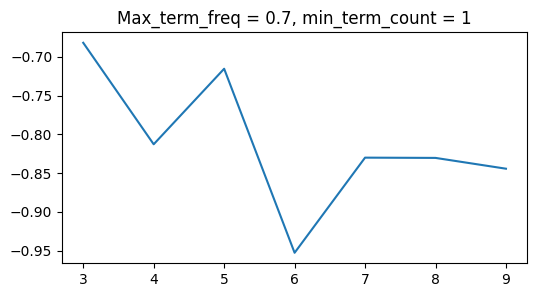

In [36]:
plt.figure(figsize = (6,3))
plt.plot(dict_coherence_score_topic_count.keys(),
        dict_coherence_score_topic_count.values())
plt.title('Max_term_freq = {}, min_term_count = {}'.format(max_term_freq, min_term_count))

# 3. Visualize model

## pyLDAvis

In [37]:
pyLDAvis.enable_notebook()

## topic count = 5

In [38]:
Lda5, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 5, Word2id)

In [39]:
vis5 = pyLDAvis.gensim_models.prepare(Lda5, Corpus, D, sort_topics = False)
vis5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.089884  0.058778       1        1  14.481532
1      0.107787 -0.012025       2        1  29.846563
2      0.040848 -0.102433       3        1   8.820302
3     -0.148116 -0.090632       4        1  32.043396
4     -0.090403  0.146312       5        1  14.808207, topic_info=          Term         Freq        Total Category  logprob  loglift
370      blood  1558.000000  1558.000000  Default  30.0000  30.0000
371   pressure   728.000000   728.000000  Default  29.0000  29.0000
621      level   760.000000   760.000000  Default  28.0000  28.0000
138  infection   610.000000   610.000000  Default  27.0000  27.0000
135       type   388.000000   388.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
221      heart   110.524946   964.581864   Topic5  -4.9217  -0.2565
40         get   103.209754   694.556772   Topic5  -4.9902   0.0035
93        make    98.835610   475.641368   Topic5  -5.0335   0.3388
122    disease   100.643277   610.963497   Topic5  -5.0154   0.1065
123       know    99.665517  1037.756779   Topic5  -5.0251  -0.4330

[422 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2006      1  0.948627      125mg
2333      5  0.905571   abortion
923       3  0.931740    acitrom
612       2  0.989342     active
1055      1  0.948673  addictive
...     ...       ...        ...
171       2  0.194115     worsen
171       3  0.003663     worsen
171       4  0.706872     worsen
171       5  0.010988     worsen
1475      3  0.960703  wrestling

[927 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

### Check topic estimations for model with 5 topics

In [43]:
list_topic_estimation = []
for i in range(len(Corpus)):   
    topic_estimation = Lda5.get_document_topics(Corpus[i])
    list_topic_estimation.append(topic_estimation)

In [44]:
df['topic_estimation'] = list_topic_estimation

In [46]:
topic_count = 5
for i in range(topic_count):
    column_name = 'topic' + str(i)
    df[column_name] = 0.0
    
for i in range(len(df)):
# for i in range(2):
#     print('i: ', i)
    for j in df.iloc[i].loc['topic_estimation']:
#         print('j: ', j)
        for k in range(topic_count):
#             print('k: ', k)
            if k == j[0]:
                estimation = j[1]
#                 print('estimation: ', estimation)
                column_name = 'topic' + str(k)
#                 print('column_name: ', column_name)
                df.at[i, column_name] = estimation

In [47]:
df.head(2)

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, antibiotic, fight, bacteria, used, treat, acne, appears, spot, pimple, face, chest, back, medicine, work, attacking, bacteria, cause, pimple, acnesol, gel, meant, external, use, used, advised, doctor, normally, wash, dry, affected, area, applying, thin, layer, medicine, applied, broken, damaged, skin, avoid, contact, eye, nose, mouth, rinse, water, accidentally, get, area, may, take, several, week, symptom, improve, keep, using, medicine, regularly, stop, using, soon, acne, start, get, better, ask, doctor, stop, treatment, common, side, effect, like, minor, itching, burning, redness, skin, oily, skin, may, seen, people, usually, temporary, resolve, consult, doctor, bother, go, away, safe, medicine, inform, doctor, problem, bowel, ...]","[(3, 0.89036494), (4, 0.10339236)]",0.0,0.0,0.0,0.890365,0.103392
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, used, treating, various, respiratory, tract, disorder, associated, excessive, mucus, work, thinning, loosens, mucus, nose, windpipe, lung, make, easier, cough, ambrodil, syrup, taken, food, better, result, suggested, take, time, every, day, dose, often, take, depends, taking, doctor, decide, much, need, improve, symptom, advised, use, day, without, doctor, consultation, common, side, effect, medicine, include, vomiting, nausea, stomach, upset, talk, doctor, worried, side, effect, would, go, away, generally, advised, take, alcohol, treatment, taking, medic

In [100]:
# df[df.topic0 > 0.9]
# general antibiotics and statins

In [99]:
# df[df.topic1 > 0.9]
# high blood pressure, and also describes drugs used to treat mental diorders

In [98]:
# df[df.topic2 > 0.9]
# anti-coagulant to prevent or treat heart attack and stroke, and other heart conditions

In [97]:
# df[df.topic3 > 0.9]
# allergic symptoms in the airway, anti-inflammatory for varies symptoms, also drugs for digestive tract symptoms

In [96]:
# df[df.topic4 > 0.9]
# antibiotics, antifungals

## also see topic count = 4

In [40]:
Lda4, Coherence_score = train_model_get_coherence_score(Corpus, Id2word, 4, Word2id)

In [41]:
print('This model has coherence score = {}'.format(Coherence_score))

This model has coherence score = -0.7015554835960036


In [42]:
vis4 = pyLDAvis.gensim_models.prepare(Lda4, Corpus, D, sort_topics = False)
vis4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.040904  0.143296       1        1  25.052769
1     -0.100963 -0.138742       2        1  19.536059
2     -0.052269  0.029473       3        1  23.114700
3      0.194136 -0.034027       4        1  32.296472, topic_info=          Term         Freq        Total Category  logprob  loglift
370      blood  1590.000000  1590.000000  Default  30.0000  30.0000
371   pressure   744.000000   744.000000  Default  29.0000  29.0000
138  infection   603.000000   603.000000  Default  28.0000  28.0000
369       high   528.000000   528.000000  Default  27.0000  27.0000
621      level   777.000000   777.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
5        treat   246.359027   614.807426   Topic4  -4.8999   0.2157
123       know   278.315117  1034.664927   Topic4  -4.7780  -0.1829
49        stop   246.459526   696.682805   Topic4  -4.8995   0.0911
65     consult   247.255693   751.260303   Topic4  -4.8963   0.0189
210       pain   219.746348   799.887960   Topic4  -5.0142  -0.1618

[339 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1711      2  0.951254    acidity
6         3  0.983194       acne
6         4  0.008779       acne
612       4  0.981314     active
271       3  0.973216    adjusts
...     ...       ...        ...
171       2  0.637819     worsen
171       3  0.248453     worsen
171       4  0.014833     worsen
208       1  0.825995  worsening
208       3  0.170308  worsening

[707 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

# Save model
- best coherence score (and visually best separations) with LDA model with 5 topics
- to show on streamlit
    - good instr: https://medium.com/@lelwonger/incorporating-functions-with-html-output-in-streamlit-pyldavis-lime-25b13717d913
    

In [264]:
# Lda4.save('../models/lda4.model')

In [265]:
# for visualization
# pyLDAvis.save_html(vis4, '../models/vis4.html')

In [266]:
# tempfile4 = datapath('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4.model')

In [267]:
# Lda4.save(tempfile4)

In [268]:
# save Corpus as well
# corpora.MmCorpus.serialize('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_corpus', Corpus)

In [216]:
# corpora.Dictionary.save('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda4_dictionary')
# not needed

In [53]:
Lda5.save('../models/lda5.model')

# for visualization
pyLDAvis.save_html(vis5, '../models/vis5.html')
tempfile5 = datapath('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5.model')
Lda5.save(tempfile5)

# save Corpus as well
corpora.MmCorpus.serialize('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5_corpus', Corpus)

# Check how to use model

## from model, get topic-term matrix

In [54]:
lda_fromload = models.LdaModel.load(tempfile5)

In [55]:
lda_fromload

In [56]:
# topics-term matrix
#https://stackoverflow.com/questions/47424335/access-term-topic-matrix-generated-by-gensim-lda

df_topic_term_matrix = pd.DataFrame(lda_fromload.get_topics(), 
                                     columns = lda_fromload.id2word.values(), 
                                     index=[f'topic {i}' for i in range(lda_fromload.num_topics)])

In [57]:
df_topic_term_matrix

,10000iu,100iu,100mcg,100mg,10mg,120mg,125mg,1500mcg,15mg,180mg,...,wrong,xl,xp,xps,xr,year,yellow,yellowing,yellowness,zone
topic 0,0.000268,0.000140,0.000013,0.000149,0.000477,0.000268,0.000653,0.000015,0.000013,0.000141,...,0.000013,0.000014,0.000014,0.000013,0.000013,0.000822,0.000013,0.002619,0.000014,0.000013
topic 1,0.000007,0.000007,0.000007,0.000063,0.000525,0.000007,0.000007,0.000100,0.000008,0.000007,...,0.000038,0.000007,0.000007,0.000007,0.000101,0.000014,0.000007,0.000075,0.000008,0.000070
topic 2,0.000024,0.000022,0.000022,0.000025,0.000023,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000234,0.000022,0.002735,0.000663,0.000022
topic 3,0.000006,0.000006,0.000006,0.000846,0.000443,0.000007,0.000006,0.000006,0.000185,0.000006,...,0.000006,0.000006,0.000066,0.000096,0.000006,0.000008,0.000006,0.000011,0.000006,0.000006
topic 4,0.000013,0.000013,0.000326,0.000663,0.000521,0.000013,0.000015,0.000013,0.000013,0.000013,...,0.000013,0.000514,0.000263,0.000013,0.000013,0.000150,0.000514,0.000023,0.000013,0.000013


In [58]:
pd.set_option('display.max_columns', None)
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:80]

take           0.017342
infection      0.013649
cholesterol    0.013431
level          0.013392
day            0.012157
                 ...   
every          0.003509
generally      0.003489
pregnancy      0.003452
urinary        0.003448
function       0.003416
Name: topic 0, Length: 80, dtype: float32

## from model, get topic probabilities for each entry

In [59]:
df.iloc[1]['Introduction']

"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day.\xa0 The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms.\xa0 It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may 

In [60]:
df_topic_term_matrix.loc['topic 0'].sort_values(ascending = False)[:50]

take           0.017342
infection      0.013649
cholesterol    0.013431
level          0.013392
day            0.012157
heart          0.011826
disease        0.011110
prescribed     0.010784
blood          0.010772
include        0.010267
tablet         0.010259
liver          0.009097
regularly      0.009020
condition      0.008873
use            0.007968
feel           0.007961
pain           0.007717
antibiotic     0.007656
lead           0.007623
help           0.006920
stop           0.006901
high           0.006874
try            0.006852
stomach        0.006696
mild           0.006435
know           0.006346
let            0.006268
safe           0.006217
injection      0.006182
usually        0.006166
increase       0.006029
sugar          0.005972
risk           0.005813
stroke         0.005728
monitor        0.005679
get            0.005656
consult        0.005608
people         0.005606
meal           0.005225
per            0.005135
stopping       0.005126
patient        0

In [61]:
len(Corpus)

1000

In [62]:
lda_corpus = corpora.MmCorpus('/Users/carmen/Documents/machine_learning_exercises/streamlit_app/models/lda5_corpus')

In [63]:
len(lda_corpus)

1000

In [64]:
def get_medication_name(text):
    
    first_sentence = text.partition('.')[0]
    name = ' '.join(re.findall(r'\b[A-Z][a-z]+|\b[A-Z]\b', first_sentence))
    
    return name

In [65]:
df['medication_name'] = df['Introduction'].apply(lambda x: get_medication_name(x))

In [66]:
df.head(2)

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, antibiotic, fight, bacteria, used, treat, acne, appears, spot, pimple, face, chest, back, medicine, work, attacking, bacteria, cause, pimple, acnesol, gel, meant, external, use, used, advised, doctor, normally, wash, dry, affected, area, applying, thin, layer, medicine, applied, broken, damaged, skin, avoid, contact, eye, nose, mouth, rinse, water, accidentally, get, area, may, take, several, week, symptom, improve, keep, using, medicine, regularly, stop, using, soon, acne, start, get, better, ask, doctor, stop, treatment, common, side, effect, like, minor, itching, burning, redness, skin, oily, skin, may, seen, people, usually, temporary, resolve, consult, doctor, bother, go, away, safe, medicine, inform, doctor, problem, bowel, ...]","[(3, 0.89036494), (4, 0.10339236)]",0.0,0.0,0.0,0.890365,0.103392,Acnesol Gel
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, used, treating, various, respiratory, tract, disorder, associated, excessive, mucus, work, thinning, loosens, mucus, nose, windpipe, lung, make, easier, cough, ambrodil, syrup, taken, food, better, result, suggested, take, time, every, day, dose, often, take, depends, taking, doctor, decide, much, need, improve, symptom, advised, use, day, without, doctor, consultation, common, side, effect, medicine, include, vomiting, nausea, stomach, upset, talk, doctor, worried, side, effect, would, go, away, generally, advised, take, alcoh

In [67]:
list_topic_estimation = []
for i in range(len(lda_corpus)):   
    topic_estimation = lda_fromload.get_document_topics(lda_corpus[i])
    list_topic_estimation.append(topic_estimation)

In [68]:
list_topic_estimation[:2]

[[(3, 0.8903576), (4, 0.1033997)], [(3, 0.015753295), (4, 0.9761814)]]

In [69]:
topic_count = 5
for i in range(topic_count):
    column_name = 'topic' + str(i)
    df[column_name] = 0.0

In [70]:
df['topic_estimation'] = list_topic_estimation

In [71]:
for i in range(len(df)):
# for i in range(2):
#     print('i: ', i)
    for j in df.iloc[i].loc['topic_estimation']:
#         print('j: ', j)
        for k in range(topic_count):
#             print('k: ', k)
            if k == j[0]:
                estimation = j[1]
#                 print('estimation: ', estimation)
                column_name = 'topic' + str(k)
#                 print('column_name: ', column_name)
                df.at[i, column_name] = estimation

In [72]:
df.head(2)

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
0,"Acnesol Gel is an antibiotic that fights bacteria. It is used to treat acne, which appears as spots or pimples on your face, chest or back. This medicine works by attacking the bacteria that cause these pimples.Acnesol Gel is only meant for external use and should be used as advised by your doctor. You should normally wash and dry the affected area before applying a thin layer of the medicine. It should not be applied to broken or damaged skin. Avoid any contact with your eyes, nose, or mouth. Rinse it off with water if you accidentally get it in these areas. It may take several weeks for your symptoms to improve, but you should keep using this medicine regularly. Do not stop using it as soon as your acne starts to get better. Ask your doctor when you should stop treatment.Common side effects like minor itching, burning, or redness of the skin and oily skin may be seen in some people. These are usually temporary and resolve on their own. Consult your doctor if they bother you or do not go away.It is a safe medicine, but you should inform your doctor if you have any problems with your bowels (intestines). Also, inform the doctor if you have ever had bloody diarrhea caused by taking antibiotics or if you are using any other medicines to treat skin conditions. Consult your doctor about using this medicine if you are pregnant or breastfeeding.","[acnesol, gel, antibiotic, fight, bacteria, used, treat, acne, appears, spot, pimple, face, chest, back, medicine, work, attacking, bacteria, cause, pimple, acnesol, gel, meant, external, use, used, advised, doctor, normally, wash, dry, affected, area, applying, thin, layer, medicine, applied, broken, damaged, skin, avoid, contact, eye, nose, mouth, rinse, water, accidentally, get, area, may, take, several, week, symptom, improve, keep, using, medicine, regularly, stop, using, soon, acne, start, get, better, ask, doctor, stop, treatment, common, side, effect, like, minor, itching, burning, redness, skin, oily, skin, may, seen, people, usually, temporary, resolve, consult, doctor, bother, go, away, safe, medicine, inform, doctor, problem, bowel, ...]","[(3, 0.8903576), (4, 0.1033997)]",0.0,0.0,0.0,0.890358,0.103400,Acnesol Gel
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, used, treating, various, respiratory, tract, disorder, associated, excessive, mucus, work, thinning, loosens, mucus, nose, windpipe, lung, make, easier, cough, ambrodil, syrup, taken, food, better, result, suggested, take, time, every, day, dose, often, take, depends, taking, doctor, decide, much, need, improve, symptom, advised, use, day, without, doctor, consultation, common, side, effect, medicine, include, vomiting, nausea, stomach, upset, talk, doctor, worried, side, effect, would, go, away, generally, advised, take, alcohol

#  Check topics

(array([777.,  31.,  49.,   9.,  15.,   5.,  17.,  19.,   4.,  74.]),
 array([0.       , 0.0994003, 0.1988006, 0.2982009, 0.3976012, 0.4970015,
        0.5964018, 0.6958021, 0.7952024, 0.8946027, 0.994003 ]),
 <BarContainer object of 10 artists>)

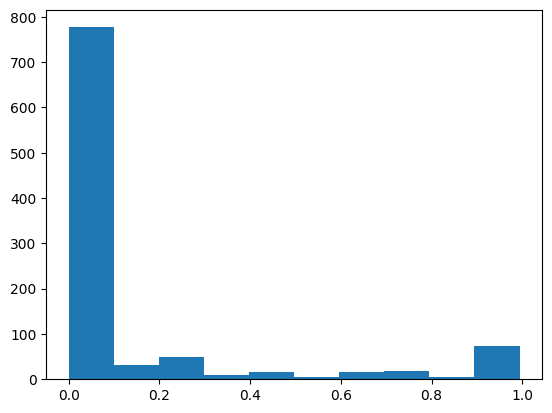

In [73]:
plt.hist(df.topic0)

In [74]:
df_topic0 = df[df.topic0 > 0.9]

In [75]:
df_topic0
# (Topic 1) general antibiotics and statins

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
2,"Augmentin 625 Duo Tablet is a penicillin-type of antibiotic that helps your body fight infections caused by bacteria. It is used to treat infections of the lungs (e.g., pneumonia), ear, nasal sinus, urinary tract, skin and soft tissue. It will not work for viral infections such as the common cold.Augmentin 625 Duo Tablet is best taken with a meal to reduce the chance of a stomach upset. You should take it regularly at evenly spaced intervals as per the schedule prescribed by your doctor. Taking it at the same time every day will help you to remember to take it. The dose will depend on what you are being treated for, but you should always complete a full course of this antibiotic as prescribed by your doctor. Do not stop taking it until you have finished, even when you feel better. If you stop taking it early, some bacteria may survive and the infection may come back or worsen.The most common side effects of this medicine include vomiting, nausea, and diarrhea. These are usually mild but let your doctor know if they bother you or will not go away.Before taking it, let your doctor know if you are allergic to any antibiotics or have any kidney or liver problems. You should also let your healthcare team know about all other medicines you are taking as they may affect, or be affected by, this medicine. This medicine is generally regarded as safe to use during pregnancy and breastfeeding if prescribed by a doctor.","[augmentin, duo, tablet, penicillin, type, antibiotic, help, body, fight, infection, caused, bacteria, used, treat, infection, lung, pneumonia, ear, nasal, sinus, urinary, tract, skin, soft, tissue, work, viral, infection, common, cold, augmentin, duo, tablet, best, taken, meal, reduce, chance, stomach, upset, take, regularly, evenly, spaced, interval, per, schedule, prescribed, doctor, taking, time, every, day, help, remember, take, dose, depend, treated, always, complete, full, course, antibiotic, prescribed, doctor, stop, taking, finished, even, feel, better, stop, taking, early, bacteria, may, survive, infection, may, come, back, worsen, common, side, effect, medicine, include, vomiting, nausea, diarrhea, usually, mild, let, doctor, know, bother, go, away, taking, ...]","[(0, 0.9920769)]",0.992077,0.0,0.0,0.0,0.0,Augmentin Duo Tablet
35,"Augmentin DDS Suspension is a penicillin-type of antibiotic that helps your body fight infections caused by bacteria. It is used to treat infections of the lungs (e.g., pneumonia), ear, nasal sinus, urinary tract, skin and soft tissue. It will not work for viral infections such as the common cold.Augmentin DDS Suspension is best taken with a meal to reduce the chance of a stomach upset. You should take it regularly at evenly spaced intervals as per the schedule prescribed by your doctor. Taking it at the same time every day will help you to remember to take it. The dose will depend on what you are being treated for, but you should always complete a full course of this antibiotic as prescribed by your doctor. Do not stop taking it until you have finished, even when you feel better. If you stop taking it early, some bacteria may survive and the infection may come back or worsen.The most common side effects of this medicine include vomiting, nausea, and diarrhea. These are usually mild but let your doctor know if they bother you or will not go away.Before taking it, let your doctor know if you are allergic to any antibiotics or have any kidney or liver problems. You should also let your healthcare team know about all other medicines you are taking as they may affect, or be affected by, this medicine. This medicine is generally regarded as safe to use during pregnancy and breastfeeding if prescribed by a doctor.","[augmentin, dd, suspension, penicillin, type, antibiotic, help, body, fight, infection, caused, bacteria, used, treat, infection, lung, pneumonia, ear, nasal, sinus, urinary, tract, skin

In [76]:
len(df_topic0)

74

(array([617.,  68.,  47.,   6.,  11.,   6.,  16.,  16.,  22., 191.]),
 array([0.        , 0.09959205, 0.1991841 , 0.29877614, 0.39836819,
        0.49796024, 0.59755229, 0.69714434, 0.79673638, 0.89632843,
        0.99592048]),
 <BarContainer object of 10 artists>)

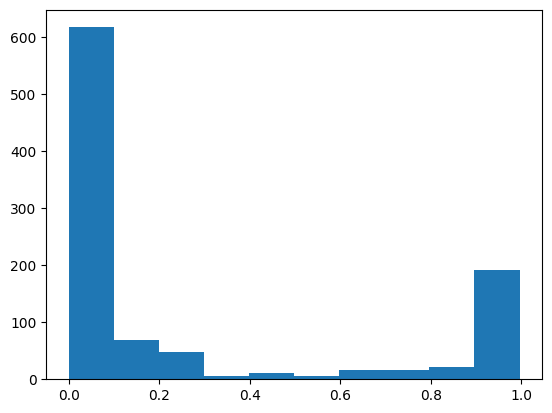

In [77]:
plt.hist(df.topic1)

In [78]:
df_topic1 = df[df.topic1 > 0.9]

In [79]:
df_topic1
# (Topic 2) high blood pressure, and also describes drugs used to treat mental diorders

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
18,"Arkamin Tablet is a medicine used in the treatment of hypertension (high blood pressure). It lowers the blood pressure by relaxing the blood vessels. Lowering the blood pressure helps to prevent future stroke and heart attack.Arkamin Tablet is also used to prevent migraine and hot flushes in women during menopause. This medicine can be taken with or without food but it is better to take it at the same time every day. You should always take this medicine as advised by the doctor and should never stop it without consulting the doctor. Most people with high blood pressure do not feel ill, but if you stop taking this medicine, your condition could get worse. This may lead to your blood pressure rising up again and increase your risk of heart disease and stroke. You should monitor your blood pressure regularly while taking this medicine.Common side effects of this medicine include dizziness, headache, nausea, fatigue, dry mouth, and constipation. Consult your doctor if these side effects bother you.Before taking this medicine, it is better to let your doctor know if you are suffering from any kidney or liver disease. Also, pregnant women and breastfeeding mothers should consult a doctor before taking it.","[arkamin, tablet, medicine, used, treatment, hypertension, high, blood, pressure, lower, blood, pressure, relaxing, blood, vessel, lowering, blood, pressure, help, prevent, future, stroke, heart, attack, arkamin, tablet, also, used, prevent, migraine, hot, flush, woman, menopause, medicine, taken, without, food, better, take, time, every, day, always, take, medicine, advised, doctor, never, stop, without, consulting, doctor, people, high, blood, pressure, feel, ill, stop, taking, medicine, condition, could, get, worse, may, lead, blood, pressure, rising, increase, risk, heart, disease, stroke, monitor, blood, pressure, regularly, taking, medicine, common, side, effect, medicine, include, dizziness, headache, nausea, fatigue, dry, mouth, constipation, consult, doctor, side, effect, bother, taking, ...]","[(0, 0.07078932), (1, 0.922175)]",0.070789,0.922175,0.000000,0.000000,0.000000,Arkamin Tablet
24,"Amlokind-AT Tablet is used to treat hypertension (high blood pressure). This is a combination of two medicines that controls blood pressure when a single medication is not effective. It helps to lower high blood pressure and thus reduces the chances of future heart attack and stroke.You can take Amlokind-AT Tablet at any time of day, on empty stomach, but it is best to take it at the same time each day. Keep taking it for as long as advised by your doctor. Even if you feel well, do not stop this medicine on your own because high blood pressure often has no symptoms. If you stop taking it, your condition may get worse. Keeping active with regular exercise, reducing your weight and eating a healthy diet will also help control your blood pressure. Follow your doctor’s advice while taking this medicine.It may cause side effects like headache, ankle swelling, slow heart rate, and nausea. It may also cause dizziness, so do not drive or do anything that requires mental focus until you know how this medicine affects you. This might raise the level of potassium in the blood, hence avoid potassium rich food or supplements. You may be asked for regular monitoring of blood pressure, kidney function, and electrolytes level while on the treatment.Before taking it, let your doctor know if you have any liver or kidney problems. Pregnant or breastfeeding women should also consult their doctor for advice before taking this medicine. You also need to tell your doctor what other medicines you are taking especially those used to treat high blood pressure or heart conditions.","[amlokind, tablet, used, treat, hypertension, high, blood, pressure, combination, two, medicine, control, blood, pressure, single, medication, effective, help, lower, high, blood, pressure, 

(array([824.,  29.,  43.,  24.,   7.,  12.,   1.,   5.,   4.,  51.]),
 array([0.        , 0.09931448, 0.19862895, 0.29794343, 0.3972579 ,
        0.49657238, 0.59588685, 0.69520133, 0.7945158 , 0.89383028,
        0.99314475]),
 <BarContainer object of 10 artists>)

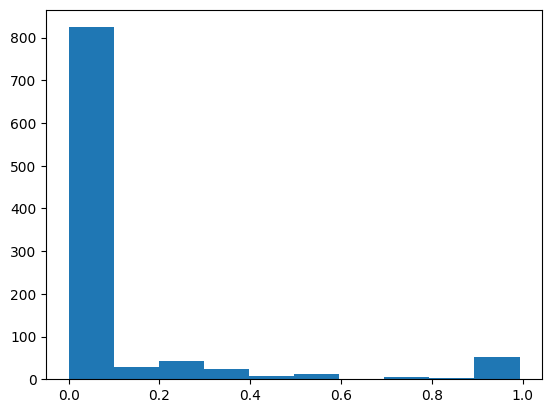

In [80]:
plt.hist(df.topic2)

In [81]:
df_topic2 = df[df.topic2 > 0.9]

In [82]:
df_topic2
# (Topic 3) anti-coagulant to prevent or treat heart attack and stroke, and other heart conditions

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
44,"Acitrom 2 Tablet is an oral anticoagulant which helps to prevent formation of harmful blood clots in the legs, lungs, brain and heart. It is used for deep vein thrombosis, pulmonary embolism and stroke prevention.Acitrom 2 Tablet should be taken as advised by the doctor. You may take it with or without food but it is better to take it at a fixed time. This medicine should not be stopped abruptly without consulting the doctor. You should take this medicine regularly to get the most benefit, even if you feel fine. It is preventing future harm.Use of this medicine may increase your risk of bleeding. Let your doctor know immediately if you see pinpoint rash or blood in your vomits, urine, or stool. If you are going under any surgery or dental treatment then you may need to stop this medicine for some time but only after consulting with your doctor.Before taking it, you must inform the doctor if you are suffering from any kidney or liver disease. Also, let your doctor know if you are pregnant or breastfeeding and about all the other medications that you are taking regularly.","[acitrom, tablet, oral, anticoagulant, help, prevent, formation, harmful, blood, clot, leg, lung, brain, heart, used, deep, vein, thrombosis, pulmonary, embolism, stroke, prevention, acitrom, tablet, taken, advised, doctor, may, take, without, food, better, take, fixed, time, medicine, stopped, abruptly, without, consulting, doctor, take, medicine, regularly, get, benefit, even, feel, fine, preventing, future, harm, use, medicine, may, increase, risk, bleeding, let, doctor, know, immediately, see, pinpoint, rash, blood, vomit, urine, stool, going, surgery, dental, treatment, may, need, stop, medicine, time, consulting, doctor, taking, must, inform, doctor, suffering, kidney, liver, disease, also, let, doctor, know, pregnant, breastfeeding, medication, taking, regularly]","[(2, 0.98912615)]",0.0,0.000000,0.989126,0.000000,0.000000,Acitrom Tablet
86,"Angispan - TR 2.5mg Capsule is used to treat and prevent heart-related chest pain (angina). Angina occurs when the heart muscle is not getting enough blood. This medicine works by relaxing and widening blood vessels so blood can flow more easily to the heart.Angispan - TR 2.5mg Capsule should be taken in the dose and duration as advised by your doctor. It may be taken with or without food, preferably at a fixed time each day. Do not consume more than the recommended dose, as this may have harmful effects on your body. You can develop tolerance to this medicine over time, which means that the same dose becomes less effective. You have to stick to a really specific dosing schedule to prevent this from happening.The most common side effect of this medicine is headache which may be severe. This can sometimes be helped by drinking plenty of fluids and avoiding alcohol. You may also experience lightheadedness, which could increase your risk of having a fall. There are other, rarer side effects, some of them serious. Ask your doctor and read the leaflet which comes with the medicine to make sure you are keeping safe.Do not use Angispan - TR 2.5mg Capsule if you are taking medicines to treat high blood pressure in your lungs (pulmonary hypertension), erectile dysfunction or if you have anemia or glaucoma (increased pressure inside the eye). Always tell your doctor what other health conditions you have and what other medicines you are taking. It is best not to drink alcohol with this medicine as it increases some of the side effects. If you are affected by dizziness, avoid driving. If you are pregnant, planning to become pregnant, or breastfeeding, ask your doctor before taking this medicine.","[angispan, tr, 5mg, capsule, used, treat, prevent, heart, related, chest, pain, angina, angina, occurs, heart, muscle, getting, enough, blood, medicine, work, relaxing, widening, blood, vessel, blood, flow, easily, heart, angispan, tr, 5mg, c

(array([517.,  41.,  48.,  14.,  14.,  26.,  18.,  32.,  47., 243.]),
 array([0.        , 0.09944822, 0.19889644, 0.29834467, 0.39779289,
        0.49724111, 0.59668933, 0.69613755, 0.79558578, 0.895034  ,
        0.99448222]),
 <BarContainer object of 10 artists>)

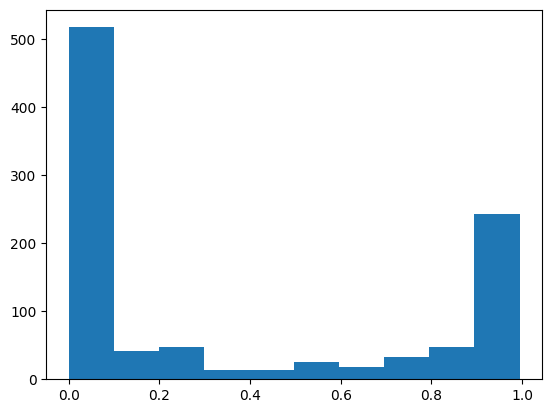

In [83]:
plt.hist(df.topic3)

In [84]:
df_topic3 = df[df.topic3 > 0.9]

In [85]:
df_topic3
# (Topic 4) mix of drugs that treat digestive tract symptoms, acne, skin infections, and also pain medications.

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
4,"Alkasol Oral Solution is a medicine used in the treatment of gout and kidney stones. It stops the production of uric acid in the body and reduces the episodes of gout attack and prevent kidney stones.Alkasol Oral Solution can be taken with or without food. This will prevent you from getting an upset stomach. Take it regularly and do not stop taking the medicine even if you get better until that doctor tell you it is alright to stop.The most common side effect of this medicine is stomach pain. It may also cause diarrhea, excessive production of urine, tiredness, etc. If any of these side effects does not resolve with time or get worsen, you should let your doctor know. Your doctor may help with ways to reduce or prevent these symptoms by reducing the dose or prescribing an alternative medicine.To make sure the medicine is safe for you, before taking this medicine, let your doctor know all the other medicines you are taking. Also tell your doctor if you have any problems with your heart, kidneys, or liver. If you are pregnant or breastfeeding, consult your doctor first before taking this medicine.","[alkasol, oral, solution, medicine, used, treatment, gout, kidney, stone, stop, production, uric, acid, body, reduces, episode, gout, attack, prevent, kidney, stone, alkasol, oral, solution, taken, without, food, prevent, getting, upset, stomach, take, regularly, stop, taking, medicine, even, get, better, doctor, tell, alright, stop, common, side, effect, medicine, stomach, pain, may, also, cause, diarrhea, excessive, production, urine, tiredness, etc, side, effect, resolve, time, get, worsen, let, doctor, know, doctor, may, help, way, reduce, prevent, symptom, reducing, dose, prescribing, alternative, medicine, make, sure, medicine, safe, taking, medicine, let, doctor, know, medicine, taking, also, tell, doctor, problem, heart, kidney, liver, pregnant, breastfeeding, consult, ...]","[(3, 0.98859644)]",0.0,0.000000,0.0,0.988596,0.000000,Alkasol Oral Solution
6,"Ascoril LS Syrup is a combination medicine used in the treatment of cough with mucus. It thins mucus in the nose, windpipe and lungs, making it easier to cough out. It also provides relief from runny nose, sneezing, itching, and watery eyes.Ascoril LS Syrup is taken with or without food in a dose and duration as advised by the doctor. The dose you are given will depend on your condition and how you respond to the medicine. You should keep taking this medicine for as long as your doctor recommends. If you stop treatment too early your symptoms may come back and your condition may worsen. Let your healthcare team know about all other medications you are taking as some may affect, or be affected by this medicine.The most common side effects are nausea, diarrhea, stomach pain, vomiting, muscle cramp, headache, skin rash, and increased heart rate. Most of these are temporary and usually resolve with time. Contact your doctor straight away if you are at all concerned about any of these side effects. This medicine can also cause sleepiness, so do not drive or do anything that requires mental focus until you know how this medicine affects you. Avoid drinking alcohol while taking this medicine as it can make sleepiness worse.Never support self-medication or recommend your medicine to another person. It is beneficial to have plenty of fluids while taking this medication. Before taking this medicine, you should tell your doctor if you are pregnant, planning pregnancy or breastfeeding. You should also tell your doctor if you have any kidney or liver diseases so that your doctor can prescribe a suitable dose for you.","[ascoril, syrup, combination, medicine, used, treatment, cough, mucus, thins, mucus, nose, windpipe, lung, making, easier, cough, also, provides, relief, runny, nose, sneezing, itching, watery, eye, ascoril, syrup, taken, without, food, dose, duration, advised, doctor, dose, given, de

(array([741.,  36.,  56.,  24.,  10.,  12.,  11.,  12.,  15.,  83.]),
 array([0.        , 0.09947981, 0.19895962, 0.29843944, 0.39791925,
        0.49739906, 0.59687887, 0.69635869, 0.7958385 , 0.89531831,
        0.99479812]),
 <BarContainer object of 10 artists>)

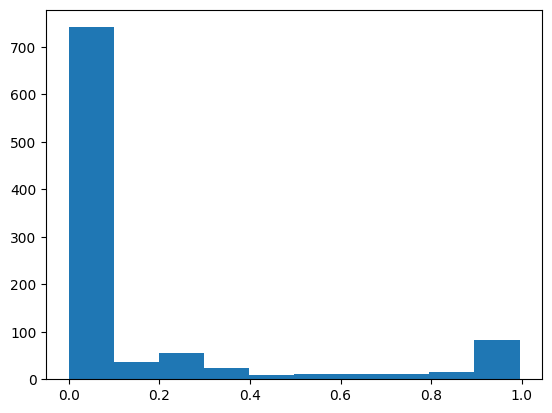

In [86]:
plt.hist(df.topic4)

In [87]:
df_topic4 = df[df.topic4 > 0.9]
df_topic4
# (Topic 5) antibiotics for airway infections, antifungals

,Introduction,tokens,topic_estimation,topic0,topic1,topic2,topic3,topic4,medication_name
1,"Ambrodil Syrup is used for treating various respiratory tract disorders associated with excessive mucus. It works by thinning and loosens mucus in the nose, windpipe and lungs and make it easier to cough out.Ambrodil Syrup should be taken with food. For better results, it is suggested to take it at the same time every day. The dose and how often you take it depends on what you are taking it for. Your doctor will decide how much you need to improve your symptoms. It is advised not to use it for more than 14 days without doctor consultation.The most common side effects of this medicine include vomiting, nausea, and stomach upset. Talk to your doctor if you are worried about side effects or they would not go away. Generally, it is advised not to take alcohol while on treatment.Before taking this medicine, tell your doctor if you have liver or kidney disease or if you have stomach problems. Your doctor should also know about all other medicines you are taking as many of these may make this medicine less effective or change the way it works. You must take doctor's advice before using this medicine if you are pregnant or breastfeeding.","[ambrodil, syrup, used, treating, various, respiratory, tract, disorder, associated, excessive, mucus, work, thinning, loosens, mucus, nose, windpipe, lung, make, easier, cough, ambrodil, syrup, taken, food, better, result, suggested, take, time, every, day, dose, often, take, depends, taking, doctor, decide, much, need, improve, symptom, advised, use, day, without, doctor, consultation, common, side, effect, medicine, include, vomiting, nausea, stomach, upset, talk, doctor, worried, side, effect, would, go, away, generally, advised, take, alcohol, treatment, taking, medicine, tell, doctor, liver, kidney, disease, stomach, problem, doctor, also, know, medicine, taking, many, may, make, medicine, le, effective, change, way, work, must, take, doctor, advice, using, medicine, ...]","[(3, 0.015753295), (4, 0.9761814)]",0.0,0.000000,0.0,0.015753,0.976181,Ambrodil Syrup
3,"Azithral 500 Tablet is an antibiotic used to treat various types of bacterial infections of the respiratory tract, ear, nose, throat, lungs, skin, and eye in adults and children. It is also effective in typhoid fever and some sexually transmitted diseases like gonorrhea.Azithral 500 Tablet is a broad-spectrum type of antibiotic effective in killing many types of gram-positive bacteria, some types of gram-negative bacteria and other microorganisms. This medicine is taken orally, preferably either one hour before or 2 hours after a meal. It should be used regularly at evenly spaced time intervals as prescribed by your doctor. Do not skip any doses and finish the full course of treatment even if you feel better. Stopping the medicine too early may lead to the return or worsening of the infection.Commonly seen side effects seen with this medicine include vomiting, nausea, stomach pain, and diarrhea. These are usually temporary and subside with the completion of treatment. Consult your doctor if you find these side effects worry you or persist for a longer duration.Inform your doctor if you have any previous history of allergy or heart problems before taking this medicine. Pregnant or breastfeeding women should consult their doctor before using this medicine.","[azithral, tablet, antibiotic, used, treat, various, type, bacterial, infection, respiratory, tract, ear, nose, throat, lung, skin, eye, adult, child, also, effective, typhoid, fever, sexually, transmitted, disease, like, gonorrhea, azithral, tablet, broad, spectrum, type, antibiotic, effective, killing, many, type, gram, positive, bacteria, type, gram, negative, bacteria, microorganism, medicine, taken, orally, preferably, either, one, hour, hour, meal, used, regularly, evenly, spaced, time, interval, prescribed, doctor, skip, dos, finish, full, course, treatment, even, feel, better, stopping,